In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20,10)
pd.set_option('display.max_rows', None)

In [2]:
# Load Dataset
df1 = pd.read_csv('D:/delhi_pp.csv')
df1.tail(3)

,Unnamed: 0,price,Address,area,latitude,longitude,Bedrooms,Bathrooms,Balcony,Status,neworold,parking,Furnished_status,Lift,Landmarks,type_of_building,desc,Price_sqft
7735,7735,7000000,"Crossings Republik, Ghaziabad, Delhi NCR",1898,28.625850,77.435336,4,3,5.0,Ready to Move,Resale,NaN,NaN,NaN,NaN,Flat,\n \n \n...,3688.092729
7736,7736,6500000,"Raj Nagar Extension, Ghaziabad, Raj Nagar Exte...",1400,28.701622,77.430153,3,3,2.0,Ready to Move,Resale,1.0,NaN,3.0,vvip mall,Flat,\n \n \n...,4642.857143
7737,7737,6500000,"sandal apartment, Shalimar Garden Extension 1,...",1750,28.693590,77.344376,3,2,3.0,Ready to Move,New Property,NaN,NaN,NaN,NaN,Flat,\n,3714.285714


In [3]:
# Drop Unnecessary Columns
df2 = df1.drop(['Unnamed: 0', 'latitude', 'longitude', 'Balcony', 'Status', 'Landmarks', 
                'Lift', 'Furnished_status', 'parking', 'desc'], axis=1)

In [4]:
# Display Unique Values in Columns
for col in df2:
    print(df2[col].unique())
df2.isnull().sum()

[ 5600000  8800000 16500000  3810000  6200000  3700000  3270000  3990000
  3500000  5500000  7300000  7700000 10500000  7200000  7000000  9500000
 15000000  4800000  5100000 14000000  6250000  8700000 13000000  4200000
  3900000 10000000  7600000  9000000  8350000 13500000  5310000 17500000
  5000000  4550000  4000000  2400000 80000000  7500000  8500000  4700000
 18000000 12400000  6000000 12500000  6380000  7400000  8400000  6400000
 19000000  4300000 23800000 10800000  4320000  3000000 16000000  3300000
  8200000  4100000  5200000 21000000  2650000  4500000  6900000 32500000
 11000000  3200000  3400000 11100000 82000000  8900000  9200000 11500000
  3600000 49000000 17200000 17000000  9900000  5150000  2630000  4600000
  5800000 26000000 20000000  6710000 16900000 12000000  2700000  3790000
 15200000  3330000 24500000 45000000  3250000  5890000 24000000 33000000
  2550000  9300000  9400000 22500000  9700000  2900000 79000000  6040000
 22000000 23500000  9800000  6600000 13200000  2800

price               0
Address             0
area                0
Bedrooms            0
Bathrooms           0
neworold            0
type_of_building    0
Price_sqft          0
dtype: int64

In [5]:
# Clean Address Column
df2.Address = df2.Address.apply(lambda x: x.strip())

In [6]:
# Handle Rare Locations
location_stats = df2.groupby('Address')['Address'].agg('count').sort_values(ascending=False)
location_stats_less10 = location_stats[location_stats <= 10]
df2.Address = df2.Address.apply(lambda x: 'other' if x in location_stats_less10 else x)

In [7]:
# Define Outlier Removal Function
def remove_outliers(df):
    df_out = pd.DataFrame()
    for address, subrows in df.groupby('Address'):
        m = subrows['Price_sqft'].mean()
        sd = subrows['Price_sqft'].std()
        cleaned = subrows[(subrows.Price_sqft > (m - sd)) & (subrows.Price_sqft <= (m + sd))]
        df_out = pd.concat([df_out, cleaned], ignore_index=True)
    return df_out
df4 = remove_outliers(df2)

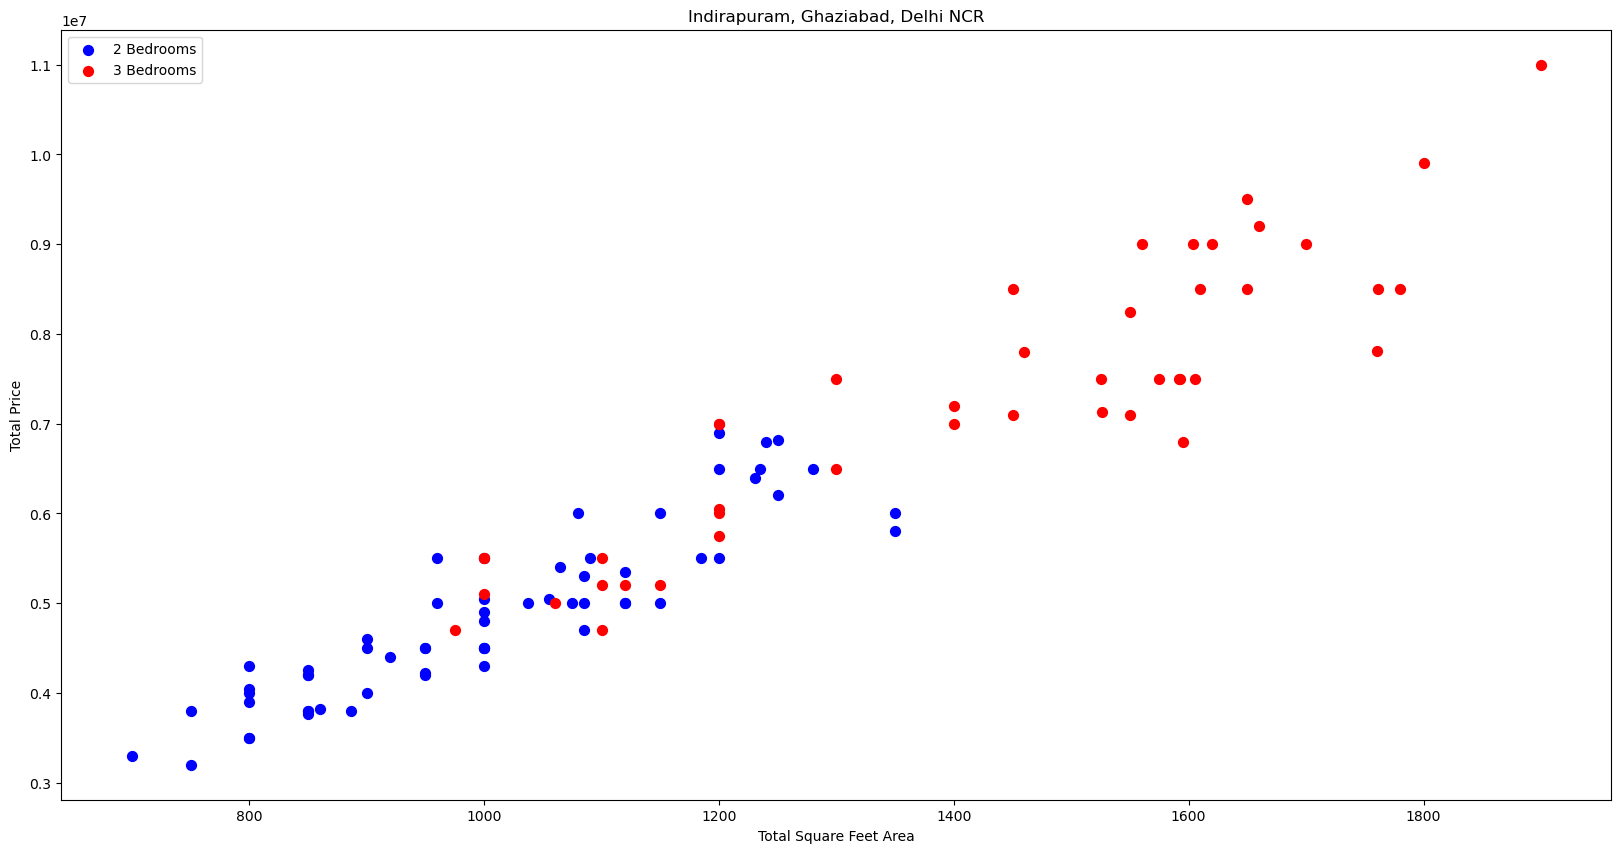

In [8]:
# Scatter Plot Function
def scatter_plot(df, location):
    b2 = df[(df.Address == location) & (df.Bedrooms == 2)]
    b3 = df[(df.Address == location) & (df.Bedrooms == 3)]
    plt.scatter(b2.area, b2.price, color='blue', label='2 Bedrooms', s=50)
    plt.scatter(b3.area, b3.price, color='red', label='3 Bedrooms', s=50)
    plt.xlabel('Total Square Feet Area')
    plt.ylabel('Total Price')
    plt.legend()
    plt.title(location)

scatter_plot(df4, 'Indirapuram, Ghaziabad, Delhi NCR')

In [9]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])  # Initialize an empty array to hold outlier indices
    
    for address, subrows in df.groupby('Address'):
        b_stats = {}
        
        # Calculate statistics for each number of Bedrooms
        for bedroom, b_subrows in subrows.groupby('Bedrooms'):  # Fixed to use subrows
            b_stats[bedroom] = {
                'mean': b_subrows.Price_sqft.mean(),
                'std': b_subrows.Price_sqft.std(),
                'count': b_subrows.shape[0]
            }
        
        # Identify outliers based on the previous bedroom's statistics
        for bedroom, b_subrows in subrows.groupby('Bedrooms'):  # Fixed to use subrows
            previous_b = b_stats.get(bedroom - 1)  # Fixed to use b_stats
            
            # Ensure previous_b is not None and count is greater than 5
            if previous_b is not None and previous_b['count'] > 5:
                # Append the indices of outliers
                outlier_indices = b_subrows[b_subrows.Price_sqft < previous_b['mean']].index.values
                exclude_indices = np.append(exclude_indices, outlier_indices)  # Append outlier indices

    return df.drop(exclude_indices, axis='index')  # Drop the outliers from the DataFrame


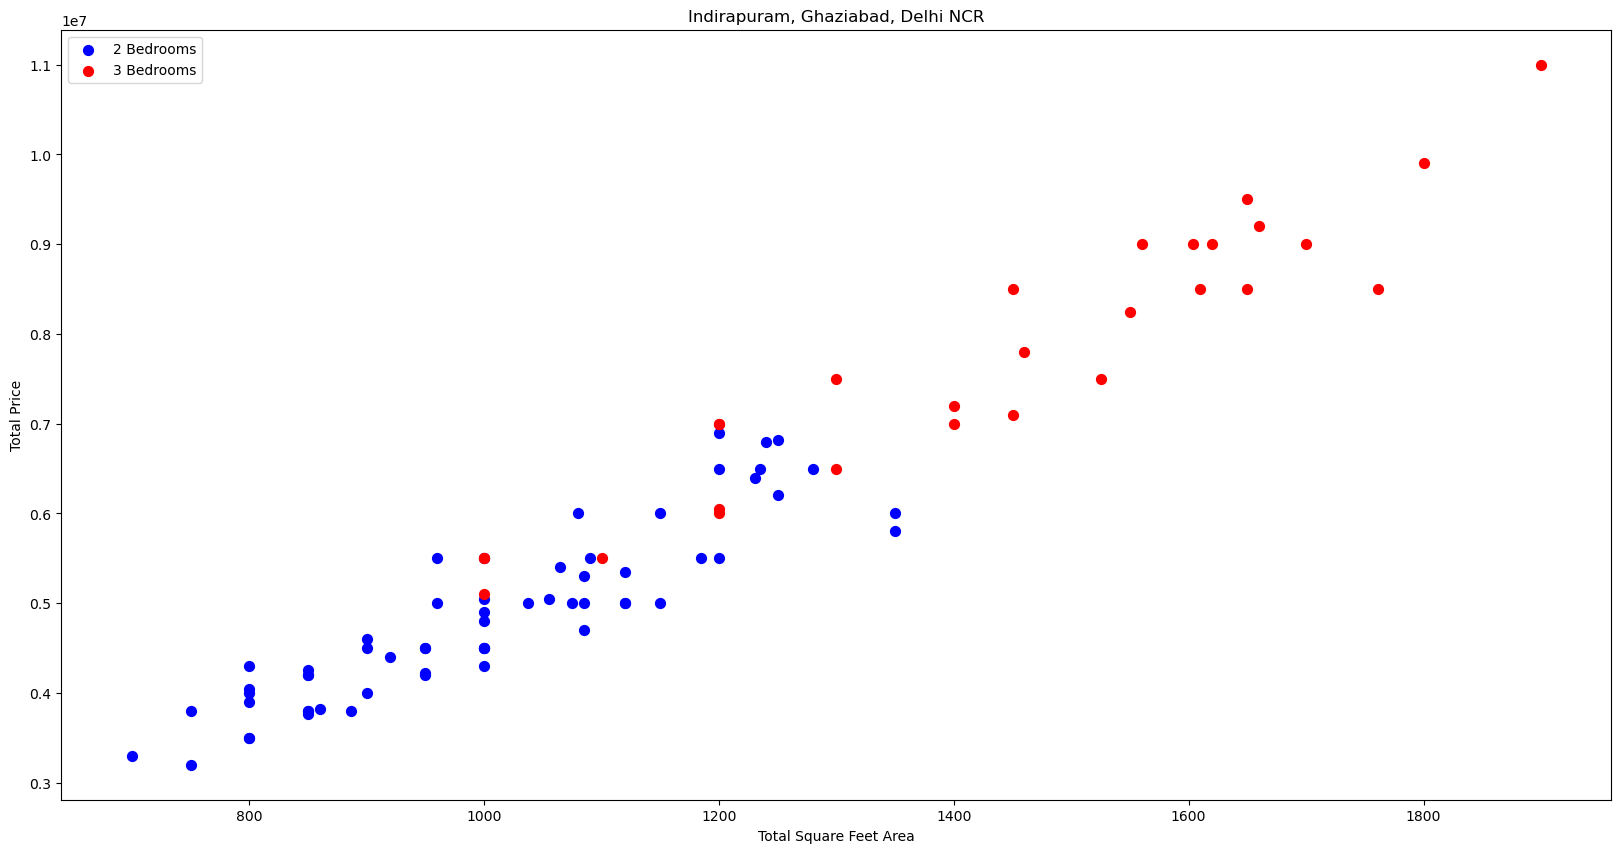

In [10]:
# Further Cleaning and Preprocessing
df5 = remove_bhk_outliers(df4)
scatter_plot(df5, 'Indirapuram, Ghaziabad, Delhi NCR')
df5 = df5[df5.Bathrooms < df5.Bedrooms + 2]

In [11]:
# One-Hot Encoding for Categorical Data
df7 = df5.drop(['Price_sqft'], axis=1)
df_dummies1 = pd.get_dummies(df7.Address).astype(int)
df_dummies2 = pd.get_dummies(df7[['type_of_building', 'neworold']]).astype(int)
df8 = pd.concat([df7, df_dummies1.drop('other', axis=1), df_dummies2], axis=1)
df9 = df8.drop(['Address', 'neworold', 'type_of_building'], axis=1)
X = df9.drop('price', axis=1)
y = df9.price

In [12]:
# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Linear Regression Model Training
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9110389388241791

In [14]:
# Model Evaluation with Cross-Validation
from sklearn.model_selection import ShuffleSplit, cross_val_score
shuffle_split = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
cross_val_score(LinearRegression(), X, y, cv=shuffle_split)

array([0.91246341, 0.93022345, 0.91438335, 0.93445989, 0.9308299 ])

In [16]:
import os
import pickle

file_path = r"C:\Users\Admin\dhp\model\Delhi_home_prices_model.pickle"

if os.path.exists(file_path):
    with open(file_path, 'rb') as file:
        model = pickle.load(file)
else:
    print(f"File not found at {file_path}")

In [17]:
import json

# Define your columns
columns = {'data_columns': [col.lower() for col in X.columns]}

# Specify the path to the model directory
model_directory = r"C:\Users\Admin\dhp\model"  # Adjust this path as needed
file_path = f"{model_directory}\\columns.json"

# Save the JSON file in the model directory
with open(file_path, 'w') as f:
    f.write(json.dumps(columns))